# Introduction
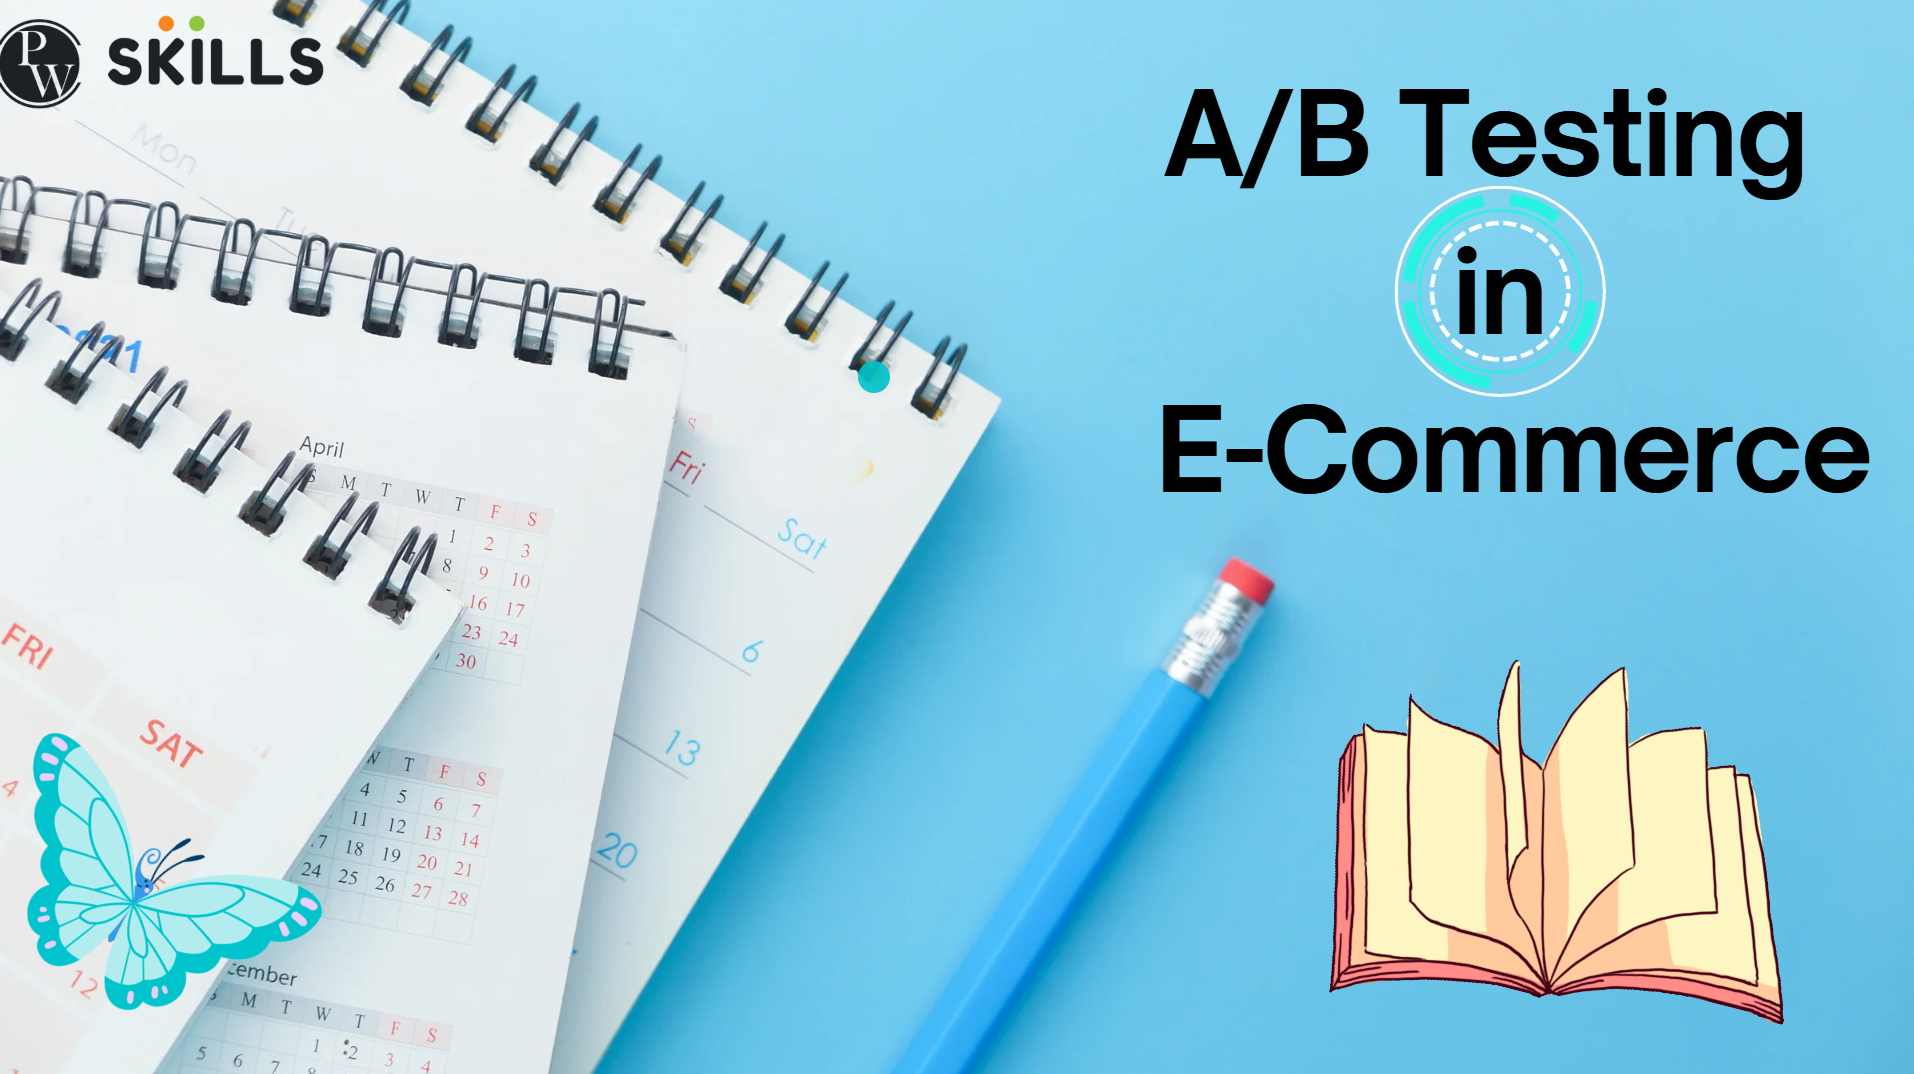
## A/B Testing in E-Commerce

- A/B testing is a widely adopted method among data analysts and data scientists to evaluate webpage performance and improve user engagement. In this project, I will analyze the results of an A/B test conducted by an e-commerce website. The primary goal is to help the company decide whether to implement the new page design, stick with the current version, or extend the experiment further before making a final decision.

## What is A/B Testing?

- A/B testing is a technique used to compare two versions of a webpage by dividing traffic between them and measuring performance based on key metrics such as conversions, sales, and user engagement. Common objectives include improving click-through rates, boosting email sign-ups, and increasing purchases. Ultimately, the insights gained from A/B testing can lead to enhanced user experience, reduced bounce rates, higher conversion rates, and minimized cart abandonment.


# Dataset Overview:
- Link:(https://raw.githubusercontent.com/MasteriNeuron/A-B-Testing-in-E-Commerce/refs/heads/main/ab_data.csv)
## Shape of DataFrame:
- The dataset contains 294,478 rows and 5 columns. This suggests that there are 294,478 recorded events or observations related to the A/B test.

## Unique Users:
- The count of unique user_id values is 290,584, which is slightly less than the number of rows. This indicates that some users appear more than once in the dataset. In an A/B test context, multiple entries per user could represent repeated interactions or visits over time.

# Variables Description

###  user_id

- Type: 6-digit number
- Description: Serves as a unique identifier for each user. Although most users appear only once, the fact that the unique count is lower than the total number of rows implies that some users have multiple records.

### timestamp

- Type: String (formatted as a datetime)
- Description: Captures the exact date and time when the event or interaction was recorded. The format (e.g., 2017-01-21 22:11:48.556739) provides precise timing information, which can be crucial for time-series analysis or understanding user behavior trends during the A/B test period.

### group

- Type: String
- Possible Values:<b> control, treatment</b>
- Description: Indicates the group to which the user was assigned during the A/B test. The <b>control group typically represents the existing version (or a baseline)</b>, while the <b>treatment group represents the new version </b>or intervention being tested.

### landing_page

- Type: String
- Possible Values:<b> old_page, new_page</b>
- Description: Specifies which landing page the user saw. This variable is directly linked to the A/B testing setup where one group is exposed to the old design and the other to the new design.

### converted

- Type: Numeric (0 or 1)
- Description: Indicates whether the user completed the desired action (conversion).
- 0 means No Conversion
- 1 means Conversion
- This binary outcome is typically the primary metric for assessing the effectiveness of the new design compared to the old one.

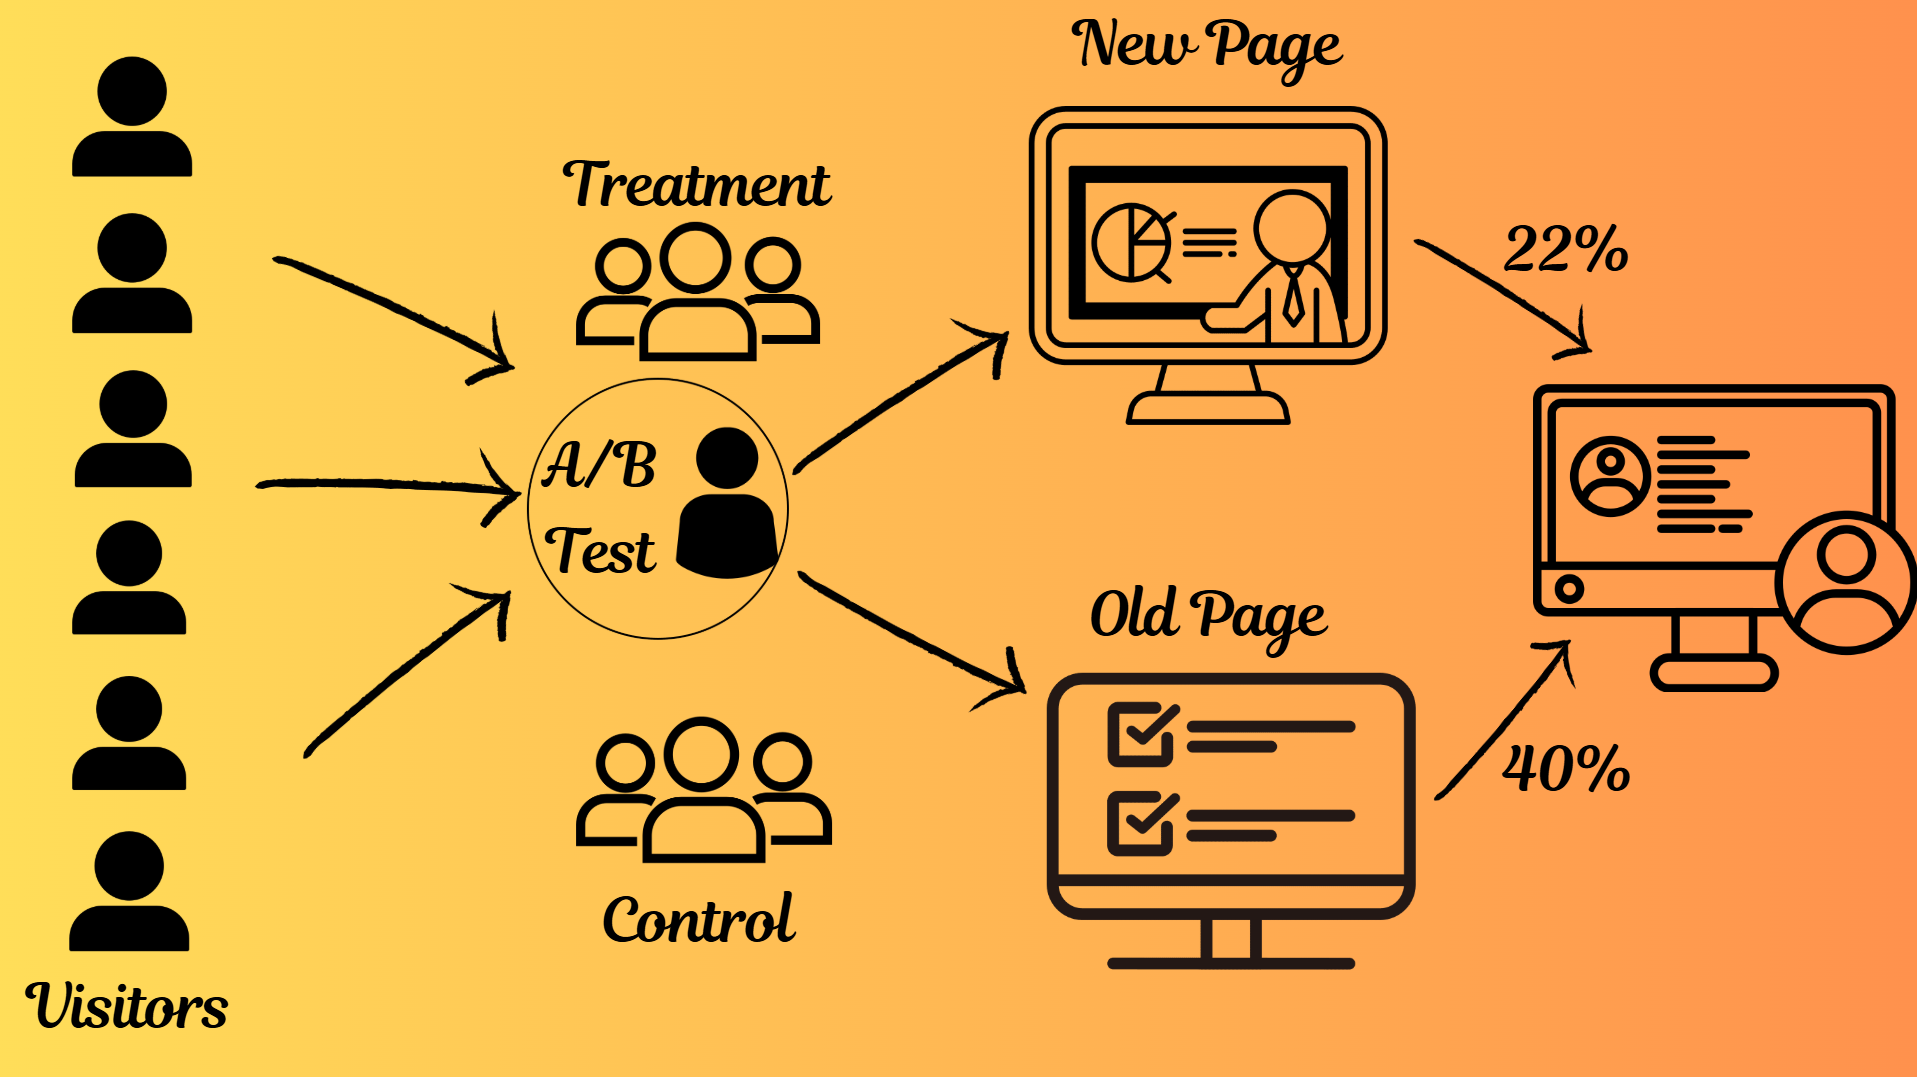


## Import Libraries


In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import norm, ttest_ind, chi2_contingency, beta

# For inline plotting in Jupyter Notebooks
%matplotlib inline



In [2]:
# Set seed for reproducibility
random.seed(42)
np.random.seed(42)

## 1. Read and Explore the Data

In [3]:
# Read the dataset
df = pd.read_csv('ab_data.csv')

# a. Inspect the first few rows
print("First few rows of df:")
df.head()


First few rows of df:


,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


## Check the number of observations (rows)

In [4]:

print("\nShape of df:", df.shape)  # Expected: (294478, 5)


Shape of df: (294478, 5)


## Number of unique users in the dataset

In [5]:
unique_users = df['user_id'].nunique()
print("\nUnique user_id count:", unique_users)


Unique user_id count: 290584


## Proportion of users who converted

In [6]:
prop_converted = df.query('converted == 1')['user_id'].nunique() / unique_users
print("\nProportion of users converted:", prop_converted)



Proportion of users converted: 0.12104245244060237


## Count rows where landing_page and group do not match

In [7]:
mismatch_count = (df.query('landing_page == "new_page" & group != "treatment"').shape[0] +
                  df.query('landing_page != "new_page" & group == "treatment"').shape[0])
print("\nMismatch count between landing_page and group:", mismatch_count)


Mismatch count between landing_page and group: 3893


## Check for missing values

In [8]:
print("\nDataFrame Info:")
df.isnull().sum()



DataFrame Info:


user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

## Proportion of Users by Group


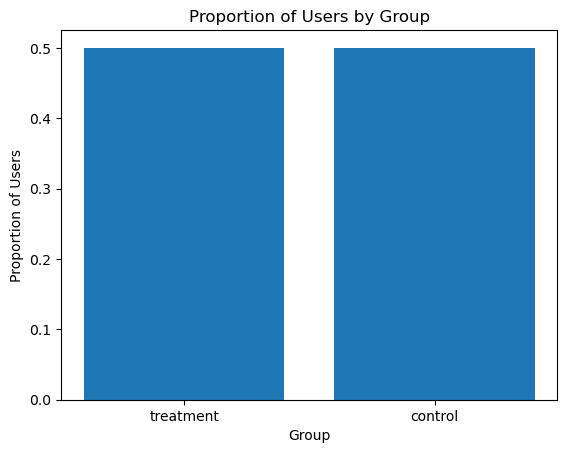

In [9]:

import matplotlib.pyplot as plt

group_counts = df['group'].value_counts()
group_proportions = group_counts / len(df)

plt.bar(group_proportions.index, group_proportions.values)
plt.xlabel('Group')
plt.ylabel('Proportion of Users')
plt.title('Proportion of Users by Group')
plt.show()


## Proportion of Converted Users


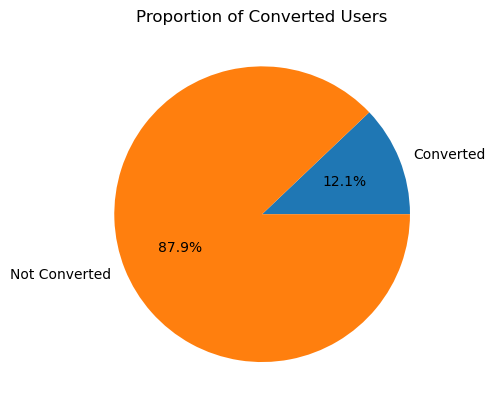

In [10]:
import matplotlib.pyplot as plt

converted_proportion = prop_converted
not_converted_proportion = 1 - converted_proportion

plt.pie([converted_proportion, not_converted_proportion], labels=['Converted', 'Not Converted'], autopct='%1.1f%%')
plt.title('Proportion of Converted Users')
plt.show()



##  Distribution of Converted Users by Group


C:\Users\drsnc\AppData\Local\Temp\ipykernel_17812\3393247703.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=converted_df, x="user_id", hue="group", shade=True)


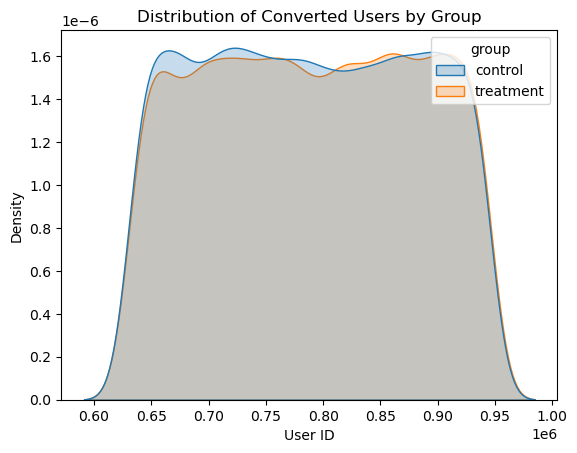

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

converted_df = df[df['converted'] == 1]

sns.kdeplot(data=converted_df, x="user_id", hue="group", shade=True)
plt.xlabel('User ID')
plt.ylabel('Density')
plt.title('Distribution of Converted Users by Group')
plt.show()



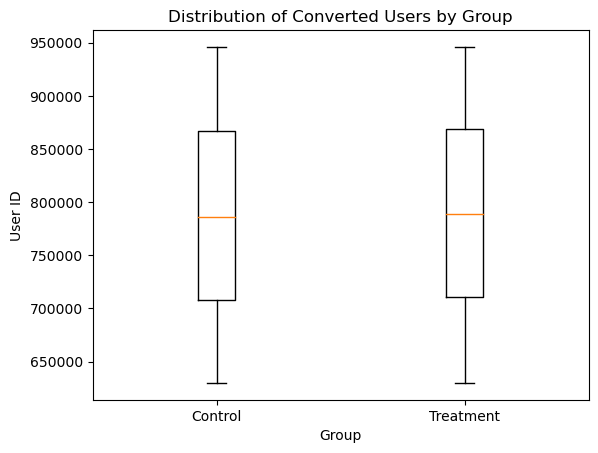

In [12]:
import matplotlib.pyplot as plt

converted_df = df[df['converted'] == 1]
group_counts = converted_df['group'].value_counts()

plt.boxplot([converted_df[converted_df['group'] == 'control']['user_id'], converted_df[converted_df['group'] == 'treatment']['user_id']], labels=['Control', 'Treatment'])
plt.xlabel('Group')
plt.ylabel('User ID')
plt.title('Distribution of Converted Users by Group')
plt.show()


## Mismatch Count between Landing Page and Group


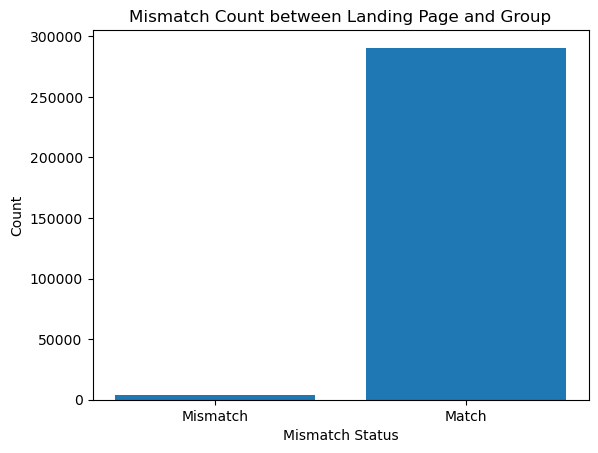

In [13]:
import matplotlib.pyplot as plt
mismatch_counts = [mismatch_count, len(df) - mismatch_count]

plt.bar(['Mismatch', 'Match'], mismatch_counts)
plt.xlabel('Mismatch Status')
plt.ylabel('Count')
plt.title('Mismatch Count between Landing Page and Group')
plt.show()


# 2. Clean the Data to Create df2

In [14]:
# =============================================================================
#    Keep only rows where landing_page matches the group assignment.
# =============================================================================

df2 = df.query('(landing_page == "new_page" & group == "treatment") | (landing_page == "old_page" & group == "control")')
df2

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
...,...,...,...,...,...
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0


## Double-check that there are no mismatches in df2

In [15]:
mismatch_df2 = df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]
print("\nMismatch count in df2:", mismatch_df2)



Mismatch count in df2: 0


## Unique user_ids before removing duplicat

In [16]:

print("\nUnique user_ids in df2 before duplicate removal:", df2['user_id'].nunique())


Unique user_ids in df2 before duplicate removal: 290584



###  Identify duplicate user_ids (if any)

In [17]:
df2.loc[:, "is_duplicate"] = df2['user_id'].duplicated()
df2.query('is_duplicate == True')

C:\Users\drsnc\AppData\Local\Temp\ipykernel_17812\3171205512.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.loc[:, "is_duplicate"] = df2['user_id'].duplicated()


,user_id,timestamp,group,landing_page,converted,is_duplicate
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0,True


### Display all rows for the duplicate user_id (if exists)

In [18]:

duplicate_user = df2[df2['user_id'] == 773192]
print("\nRows for user_id 773192:")
(duplicate_user)


Rows for user_id 773192:


,user_id,timestamp,group,landing_page,converted,is_duplicate
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0,False
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0,True


### Remove duplicate rows (keep first occurrence)

In [19]:

df2 = df2.drop_duplicates(subset='user_id', keep="first")
print("\nDuplicates after removal:", df2['user_id'].duplicated().sum())


Duplicates after removal: 0


# 4. Compute Conversion Metrics

### 4.1 Overall conversion rate (con_obs)

In [20]:
# a. Overall conversion rate (con_obs)
con_obs = df2['converted'].mean()
print("\nOverall conversion rate (con_obs):", con_obs)



Overall conversion rate (con_obs): 0.11959708724499628


### 4.2. Conversion rate for control group (old_page)

In [21]:

con_c = len(df2.query('converted == 1 & group == "control"')) / len(df2.query('group == "control"'))
print("Conversion rate for control group:", con_c)


Conversion rate for control group: 0.1203863045004612


### 4.3 Conversion rate for treatment group (new_page)

In [22]:
con_t = len(df2.query('converted == 1 & group == "treatment"')) / len(df2.query('group == "treatment"'))
print("Conversion rate for treatment group:", con_t)

Conversion rate for treatment group: 0.11880806551510564


### Difference in conversion rates (treatment - control)

In [23]:

obs_diff = con_t - con_c
print("Observed difference (treatment - control):", obs_diff)

Observed difference (treatment - control): -0.0015782389853555567


### 4.4. Probability that an individual received the new page

In [24]:
prob_new_page = len(df2.query('landing_page == "new_page"')) / len(df2)
print("Probability of receiving the new page:", prob_new_page)

Probability of receiving the new page: 0.5000619442226688


# 5. Simulation Under the Null Hypothesis (Z-Test for Proportions)

In [25]:

# =============================================================================
#    Assume: pnew = pold = overall conversion rate (con_obs)
# =============================================================================

pnew = con_obs  # Conversion probability for new page under H0
pold = con_obs  # Conversion probability for control under H0

nnew = len(df2[df2['group'] == "treatment"])
nold = len(df2[df2['group'] == "control"])
print("\nnnew (treatment sample size):", nnew)
print("nold (control sample size):", nold)


nnew (treatment sample size): 145310
nold (control sample size): 145274


## One iteration of simulation for demonstration:


Simulated difference in conversion (one iteration): -0.002397302297957274


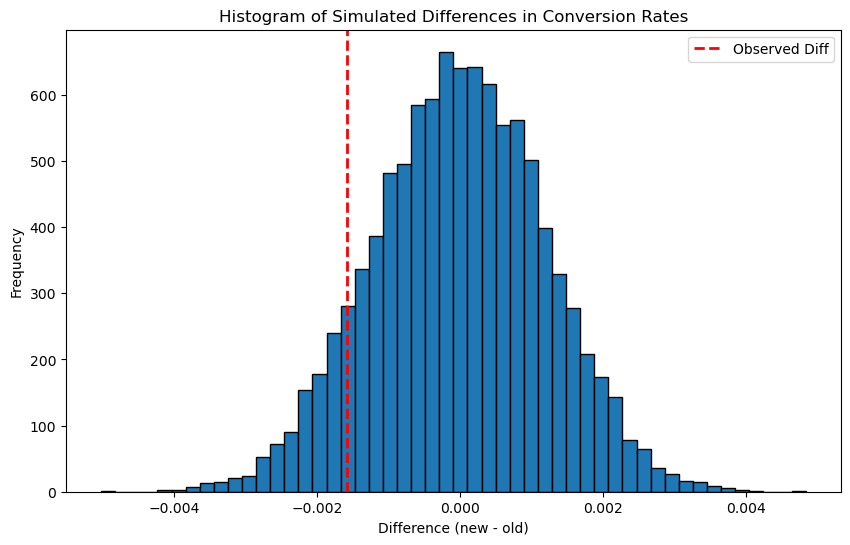

In [26]:
# One iteration of simulation for demonstration:
new_page_converted = np.random.binomial(1, pnew, nnew)
old_page_converted = np.random.binomial(1, pold, nold)
print("\nSimulated difference in conversion (one iteration):", 
      new_page_converted.mean() - old_page_converted.mean())

# Simulate 10,000 iterations to generate the sampling distribution of the difference
p_diffs = []
for _ in range(10000):
    new_page_conv = np.random.binomial(1, pnew, nnew).mean()
    old_page_conv = np.random.binomial(1, pold, nold).mean()
    p_diffs.append(new_page_conv - old_page_conv)
p_diffs = np.array(p_diffs)

# Plot a histogram of the simulated differences
plt.figure(figsize=(10, 6))
plt.hist(p_diffs, bins=50, edgecolor='k')
plt.axvline(obs_diff, color='red', linestyle='dashed', linewidth=2, label='Observed Diff')
plt.title('Histogram of Simulated Differences in Conversion Rates')
plt.xlabel('Difference (new - old)')
plt.ylabel('Frequency')
plt.legend()
plt.show()


From the histogram of simulated differences in conversion rates (new − old), the distribution is centered near zero, but the observed difference (red dashed line) is slightly negative. This indicates that, based on the simulations,<b> the new page’s conversion rate is not only failing to exceed the old page’s rate but may actually be performing slightly worse.</b> Therefore, there is no evidence that the new page outperforms the old one in terms of conversion.

In [27]:
# Calculate p-value: proportion of simulated differences greater than the observed difference
p_value_simulation = (p_diffs > obs_diff).mean()
print("Simulated p-value:", p_value_simulation)


Simulated p-value: 0.901


# 6. Built-in Z-Test Using statsmodels (Proportions Z-Test)

In [28]:
convert_old = len(df2.query('converted == 1 & group == "control"'))
convert_new = len(df2.query('converted == 1 & group == "treatment"'))
n_old = len(df2.query('group == "control"'))
n_new = len(df2.query('group == "treatment"'))
print("\nConversions for control (old_page):", convert_old)
print("Conversions for treatment (new_page):", convert_new)
print("Total in control group (n_old):", n_old)
print("Total in treatment group (n_new):", n_new)


Conversions for control (old_page): 17489
Conversions for treatment (new_page): 17264
Total in control group (n_old): 145274
Total in treatment group (n_new): 145310


In [29]:
z_score, p_value_ztest = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new],
                                                      alternative='smaller', prop_var=False)
print("\nZ-test Results:")
print("Z-score:", z_score)
print("P-value:", p_value_ztest)
z_threshold = norm.ppf(1 - 0.05)
print("Z threshold (one-tailed 5%):", z_threshold)



Z-test Results:
Z-score: 1.3109241984234394
P-value: 0.9050583127590245
Z threshold (one-tailed 5%): 1.6448536269514722


# Conclusion:
The z-score does not exceed 1.645 and the p-value, 0.905, is larger than the Type I error rate of 5%, so we cannot reject the null hypothesis. The p-value from j and k, 0.9061 gives us the same conclusion from this experiment.<b> That is, the old page is better than the new page.</b>

# 7. Additional Statistical Tests and Methods

## 7a. T-Test Example (for small sample sizes)

In [30]:
# --------------------------------------------
# For demonstration purposes, we simulate two small samples (n < 30)
np.random.seed(42)
group_A = np.random.normal(loc=50, scale=5, size=25)
group_B = np.random.normal(loc=52, scale=5, size=25)
t_stat, p_value_t = ttest_ind(group_A, group_B)
print("\nT-Test (small sample simulation):")
print("T-statistic:", t_stat)
print("P-value:", p_value_t)


T-Test (small sample simulation):
T-statistic: -1.0370017593248355
P-value: 0.3049310814662455


#### Not applicable to this dataset, as the sample sizes are large.


## 7b. Chi-Square Test for Independence

In [31]:
# -------------------------------------
# Test if there's an association between group (control vs. treatment) and conversion
contingency_table = pd.crosstab(df2['group'], df2['converted'])
print("\nContingency Table (group vs. conversion):")
contingency_table


Contingency Table (group vs. conversion):


converted,0,1
group,,
control,127785,17489
treatment,128046,17264


####  Fail to reject the null hypothesis, suggesting no significant association between the group and conversion.



In [32]:
chi2, p_value_chi2, dof, expected = chi2_contingency(contingency_table)
print("\nChi-Square Test Results:")
print("Chi2 Statistic:", chi2)
print("Degrees of Freedom:", dof)
print("P-value:", p_value_chi2)
print("Expected Frequencies:\n", expected)


Chi-Square Test Results:
Chi2 Statistic: 1.7035660051885058
Degrees of Freedom: 1
P-value: 0.19182228096235662
Expected Frequencies:
 [[127899.65274757  17374.34725243]
 [127931.34725243  17378.65274757]]


### Based on the Chi-Square Test results, we conclude that:

- There is no statistically significant difference in conversion rates between the control and treatment groups.
- The observed differences in conversion rates can be attributed to chance.
- The data does not provide sufficient evidence to suggest that the new page (treatment) has a different conversion rate than the old page (control).


### Note:
- In practical terms, this result suggests that the new page does not have a significant impact on conversion rates compared to the old page.

## 7c. ANOVA: Compare Means of a Continuous Variable

In [33]:
# We simulate a 'session_duration' variable.
# Assume: control group sessions ~ N(200, 20) and treatment group sessions ~ N(210, 20)

control_idx = df2['group'] == 'control'
treatment_idx = df2['group'] == 'treatment'
df2.loc[control_idx, 'session_duration'] = np.random.normal(200, 20, control_idx.sum())
df2.loc[treatment_idx, 'session_duration'] = np.random.normal(210, 20, treatment_idx.sum())

C:\Users\drsnc\AppData\Local\Temp\ipykernel_17812\1358062546.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.loc[control_idx, 'session_duration'] = np.random.normal(200, 20, control_idx.sum())


In [34]:
# Run ANOVA to see if there is a significant difference in session duration between groups

anova_model = smf.ols('session_duration ~ C(group)', data=df2).fit()
anova_table = sm.stats.anova_lm(anova_model, typ=2)
print("\nANOVA Results (session_duration by group):")
(anova_table)


ANOVA Results (session_duration by group):


,sum_sq,df,F,PR(>F)
C(group),7.208955e+06,1.0,18032.510753,0.0
Residual,1.161676e+08,290582.0,NaN,NaN


### Based on the ANOVA results, we conclude that:

- There is a statistically significant difference in session duration between the control and treatment groups (p-value ≈ 0.0).
- The F-statistic (18032.5108) indicates a strong association between the group and session duration.
- The results suggest that the new page (treatment) has a significant impact on session duration compared to the old page (control).

### In practical terms, this result suggests that:

- Users in the treatment group (new page) have significantly different session durations compared to users in the control group (old page).
- The new page may be more engaging or have a different design that affects user behavior, leading to changes in session duration.

## 7d. Bayesian Analysis: Update Conversion Probabilities
* Using a Beta prior for conversion rates in control and treatment groups.
* We use a non-informative prior: Beta(1,1)

In [35]:

# For control group:
success_c = len(df2.query('converted == 1 & group == "control"'))
fail_c = len(df2.query('converted == 0 & group == "control"'))
# For treatment group:
success_t = len(df2.query('converted == 1 & group == "treatment"'))
fail_t = len(df2.query('converted == 0 & group == "treatment"'))

alpha_prior = 1
beta_prior = 1

alpha_post_c = alpha_prior + success_c
beta_post_c = beta_prior + fail_c

alpha_post_t = alpha_prior + success_t
beta_post_t = beta_prior + fail_t

# Draw samples from the posterior Beta distributions
n_samples = 10000
posterior_c_samples = np.random.beta(alpha_post_c, beta_post_c, n_samples)
posterior_t_samples = np.random.beta(alpha_post_t, beta_post_t, n_samples)

# Calculate the probability that the treatment conversion rate is higher than control's
prob_t_better = np.mean(posterior_t_samples > posterior_c_samples)
print("\nBayesian Analysis:")
print("Probability that treatment conversion rate is higher than control:", prob_t_better)



Bayesian Analysis:
Probability that treatment conversion rate is higher than control: 0.0979


### Based on the Bayesian analysis results, we conclude that:

- There is only a 9.79% probability that the new page (treatment) has a higher conversion rate than the old page (control).
- The results suggest that it is unlikely that the new page has a higher conversion rate than the old page.
- The old page is likely to have a higher conversion rate than the new page.

### In practical terms, this result suggests that:

- The new page design or changes may not be as effective as the old page in terms of conversion rates.
- Further testing or optimization may be needed to improve the conversion rates of the new page.

## Plot the posterior distributions for visualization|

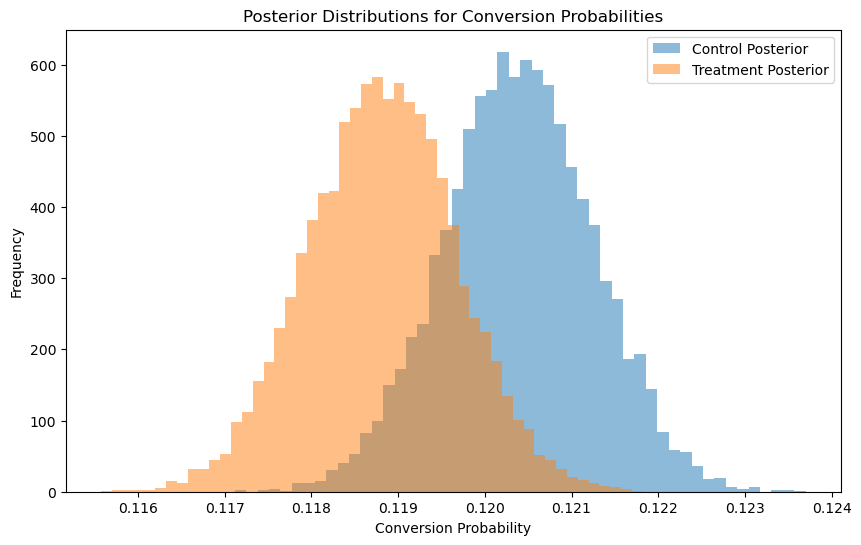

In [36]:

plt.figure(figsize=(10, 6))
plt.hist(posterior_c_samples, bins=50, alpha=0.5, label='Control Posterior')
plt.hist(posterior_t_samples, bins=50, alpha=0.5, label='Treatment Posterior')
plt.xlabel('Conversion Probability')
plt.ylabel('Frequency')
plt.title('Posterior Distributions for Conversion Probabilities')
plt.legend()
plt.show()


Based on the posterior distributions shown in the figure, the control group’s conversion probability is centered at a slightly higher value than the treatment group’s conversion probability. In other words, <b>the old page (control) appears to have a higher conversion rate on average than the new page (treatment)</b>. Given this separation in the distributions, the results suggest that the new page does not outperform the old page and may actually convert at a lower rate.